Код можно оптимизировать, переписать все в классы, обернуть в докер, и т.д... по запросу :)

Спасибо за интересное задание, старался выполнить как можно скорее!

# Анализ и подготовка данных

In [2]:
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer  

import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cat_path = '/content/drive/MyDrive/Colab Notebooks/work/categories.csv'
cat_df = pd.read_csv(cat_path)
prod_path = '/content/drive/MyDrive/Colab Notebooks/work/products.csv'
prod_df = pd.read_csv(prod_path)

In [28]:
# Прежде всего решил разобраться со структурой данных
# Максимальный путь состоит из 5 чисел, где первое у всех 1
# На втором уровне имеем 3 ветви, на 3ем - 36, на 4ом - 250, на 5ом - 715
# Также стоит отметить, что не все товары имеют путь длиной 5 и следует учесть это при классификации
max_len = 0
for i in range(len(cat_df.category_id.unique())):
  temp_len = len(cat_df.category_path[i].split('.'))
  if max_len < temp_len:
    max_len = temp_len
max_len

5

In [6]:
#функции для подготовки датафрейма
def start_pipeline(dataf):
  return dataf.copy()
def join_dfs(dataf):
  return dataf.join(cat_df.set_index('category_id'), on='category_id')

#раскрываем путь для классификации на разных уровнях
def expand_path(dataf):
  dataf[['path1', 'path2','path3','path4','path5']] = dataf['category_path'].str.rsplit('.', expand=True)
  return dataf

#если отсутствует путь у товара на каком то уровне подменяем на -1 для возможности классифицировать
def fill_none(dataf):
  dataf = dataf.fillna(value=-1)
  dataf[['path1', 'path2','path3','path4','path5']] = dataf[['path1', 'path2','path3','path4','path5']].astype(int)
  return dataf

#для удобства работы с лейблами факторизируем их после классификации можно будет вернуть обратно исходный путь
uniques_path = {}
def factorize(dataf):
  for i in ['path1','path2','path3','path4','path5']:
    dataf[i], uniques_path[i] = dataf[i].factorize()
  return dataf

def preprocessing(dataf):
  dataf['product_title'] = dataf['product_title'].map(preprocess)
  return dataf

In [7]:
def has_cyrillic(text):
  return bool(re.search('[\u0400-\u04FF]', text))

#разный стемминг для англ и рус слов
def stem(word):
  if has_cyrillic(word):
    return stem_ru.stem(word)
  else:
    return stem_en.stem(word)

stem_en = SnowballStemmer("english")
stop_words = stopwords.words("english")
stem_ru = SnowballStemmer("russian") 
stop_words.extend(stopwords.words("russian"))
#stop_words.extend(['мл','л','кг','г','мм','м'])

#были протестированы разные варианты препроцессинга
#выигрыш в точности небольшой однако большая оптимизация веса модели за счет уменьшения кол-ва уникальных токенов
# 22к токенов против 52к без предварительной обработки (lowercase)
#гипотеза в том что цифры в данной задаче не несут значительной информации и могут быть удалены
def preprocess(text):
  tokenized = nltk.word_tokenize(text)
  #return ' '.join([stem(w) for w in tokenized if (w not in stop_words and w.isalpha())])
  #return ' '.join([w for w in tokenized if (w not in stop_words and w.isalpha())])
  #return ' '.join([stem(w) for w in tokenized if w.isalnum()])
  return ' '.join([stem(w) for w in tokenized if w.isalpha()])

In [8]:
cat_df.head()

,category_id,category_title,category_path
0,13021,Базы и топы,1.10012.10113.13021
1,2740,Полки и подставки,1.10018.10110.12842.2740
2,13182,Салюты,1.10018.10118.10749.13182
3,2864,Ложки для обуви,1.10018.10110.12823.2864
4,14154,Аромабудильники и картриджи,1.10020.10227.14154


In [83]:
prod_df_prepared[prod_df_prepared.category_id==10012]

,row_number,product_title,category_id,category_title,category_path,path1,path2,path3,path4,path5


In [9]:
# подготовка датафрейма
prod_df_prepared = (prod_df
                   .pipe(start_pipeline)
                   .pipe(join_dfs)
                   .pipe(expand_path)
                   .pipe(fill_none)
                   .pipe(factorize)
                   .pipe(preprocessing)
                   )

In [78]:
prod_df_prepared.head()

,row_number,product_title,category_id,category_title,category_path,path1,path2,path3,path4,path5
0,1,термокружк с животн мл,12407,Термокружки,1.10018.10115.10586.12407,0,0,0,0,0
1,2,пластиков емкост для хранен круп,12667,Банки и крышки,1.10018.10115.10992.12667,0,0,0,1,1
2,3,контейнер с дозатор для хранен круп,13901,Емкости для специй и мельницы,1.10018.10115.10992.13901,0,0,0,1,2
3,4,контейнер для хранен яиц,13674,Контейнеры и ланч-боксы,1.10018.10115.10992.13674,0,0,0,1,3
4,5,губкодержател,13254,Принадлежности для мытья посуды,1.10018.10115.10390.13254,0,0,0,2,4


In [11]:
len(prod_df_prepared.category_path.unique())

787

In [12]:
# нужно для восстановления пути
uniques_path

{'path1': Int64Index([1], dtype='int64'),
 'path2': Int64Index([10018, 10020, 10012], dtype='int64'),
 'path3': Int64Index([10115, 10110, 10191, 10044, 10144, 10030, 10074, 10073, 10113,
             10049, 10165, 10137, 10094,  2894, 10091, 10118, 10070, 10084,
             10141, 10219, 10180, 10129, 10163, 10232, 10226, 10058, 10169,
             10186, 10086,  2673, 10184, 10197, 10185, 10227, 10150, 10205,
             10176],
            dtype='int64'),
 'path4': Int64Index([10586, 10992, 10390, 10377, 14095, 12842, 10890, 10559, 11120,
             11215,
             ...
              2898, 14154, 12418, 13921, 13196, 13087, 13224, 13035, 14379,
             12505],
            dtype='int64', length=239),
 'path5': Int64Index([12407, 12667, 13901, 13674, 13254, 11999,    -1, 13170,  2744,
             11978,
             ...
             12244, 14259, 13840, 13722, 11876, 12656, 12542,  2686, 11819,
             14066],
            dtype='int64', length=639)}

# Построение модели классификации

In [171]:
# Разные модели были опробованы
# DecisionTreeClassifier для построения логики программы выдает порядка 60% точности для предсказания 1/3 главных категорий
# XLMRoberta мультиязычная NN, но достаточно долгая и тяжеловесная
# Random Forest справляется значительно быстрее и не хуже. Выбрана для текущей задачи.

In [24]:
# Разные подходы к иерархической классификации были рассмотрены
# Можно использовать 1 классификатор для 787 различных путей категорий 77%
# Либо обучить отдельный классификатор для каждого ветвления дерева пути категорий 85-90% на каждом уровне

## Общая модель

In [14]:
clf=Pipeline([
              ('tfidf_vectorizer', TfidfVectorizer(lowercase=True)),
              ('rf_classifier', RandomForestClassifier(n_estimators=5,verbose=0,n_jobs=-1))
              ])

X_train,X_test,y_train,y_test= train_test_split(
    prod_df_prepared['product_title'], prod_df_prepared['category_id'], test_size=0.2)
#    , stratify=prod_df_prepared['category_id'])
# The least populated class in y has only 1 member, which is too few.
  
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

accuracy_score(y_test,y_pred), matthews_corrcoef(y_test,y_pred)

(0.7752021376270951, 0.770294753170435)

In [27]:
# Метрики
# Стандартный accuracy_score хорошо подходит для оценки общей картины
# MCC широко используется для мультиклассовых случаев и больше учитывает несбалансированность классов
# также смотрел метрики roc_auc и F1 с разным усреднением, в целом все метрики на одном уровне

In [20]:
# для поиска наилучших парамтров модели запускаем гридсеарч с кроссвалидацией
rf_params = {'tfidf_vectorizer__lowercase': [True,False],
             'rf_classifier__n_estimators': [2], 
             'rf_classifier__max_features': ['auto','log2',None],
             'rf_classifier__criterion': ['gini','entropy']
}

In [ ]:
rf_grid = GridSearchCV(clf, rf_params,cv=5, n_jobs=-1,verbose=True)
rf_grid.fit(X_train, y_train)

In [23]:
rf_grid.best_params_

{'rf_classifier__criterion': 'gini',
 'rf_classifier__max_features': None,
 'rf_classifier__n_estimators': 2,
 'tfidf_vectorizer__lowercase': True}

In [37]:
# Если предсказывать путь согласно иерархии отдельным классификатором для каждой ноды дерева получаем более высокую точность
# Поэтому в следующей секции я решил построить иерархию моделей
clf=Pipeline([
              ('tfidf_vectorizer', TfidfVectorizer(lowercase=True)),
              ('rf_classifier', RandomForestClassifier(n_estimators=5,verbose=0,n_jobs=-1))
              ])

X_train,X_test,y_train,y_test= train_test_split(
    prod_df_prepared['product_title'], prod_df_prepared['path2'], test_size=0.2)
  
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

accuracy_score(y_test,y_pred), matthews_corrcoef(y_test,y_pred)

(0.9761946073498282, 0.9641526137335446)

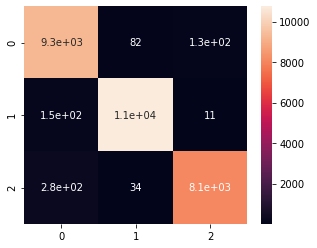

In [38]:
#конфматрица для 3х корневых директорий
conf_matrix = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(conf_matrix)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True)

## Иерархия моделей

In [ ]:
# Сохраняем все модели и метрики в отдельные словари
models = {}
metrics = {}
for j in range(len(uniques_path.keys())-1):
  prev_path = list(uniques_path.keys())[j]
  next_path = list(uniques_path.keys())[j+1]

  for i in range(len(uniques_path[prev_path])):
    clf=Pipeline([
                  ('tfidf_vectorizer', TfidfVectorizer(lowercase=True)),
                  ('rf_classifier', RandomForestClassifier(n_estimators=5,verbose=0,n_jobs=-1))
                  ])
    
    df = prod_df_prepared[prod_df_prepared[prev_path] == i].copy().reset_index(drop=True)
    #print(i)

    try:
      X_train,X_test,y_train,y_test= train_test_split(
          df['product_title'], df[next_path], test_size=0.15)
      
      clf.fit(X_train,y_train)
      y_pred=clf.predict(X_test)
      acc = accuracy_score(y_test,y_pred)
      mcc = matthews_corrcoef(y_test,y_pred)

      if models.get(prev_path):
        models[prev_path].append(clf)
        metrics[prev_path].append({'acc':acc,'mcc':mcc})
      else:
        models[prev_path] = [clf]
        metrics[prev_path] = [{'acc':acc,'mcc':mcc}]
    except:
      pass

In [62]:
# получаем дерево метрик и моделей (mcc не всегда может быть определена, так как иногда у родителя может быть только один наследник)
len(models['path2']),len(models['path3']),len(models['path4'])

(3, 37, 234)

In [102]:
class Model:
  def __init__(self,models,uniques_path,prod_df_prepared):
    self.models = models
    self.uniques_path = uniques_path
    self.cat_df = cat_df

# получение названия категорий
  def get_address(self, add):
    add = add.split('.')[1:]
    #add = self.cat_df[self.cat_df.category_id==cat_id].category_path.iloc[0].split('.')[1:]
    add_text = []
    for i in add:
      try:
        add_text.append(self.cat_df[self.cat_df.category_id==int(i)].category_title.iloc[0].strip())
      except:
        add_text.append('-')
    return add_text

#возврат к исходным ид
  def unfac(self, add):
    address = []
    for a in add.keys():
      if self.uniques_path[a][add[a]] != -1:
        address.append(str(self.uniques_path[a][add[a]]))
    return ".".join(address)

#проходим по дереву моделей предсказывая категорию от родительской до листовой    
  def predict(self,text):
    add={}
    add['path1']=0
    for i in range(len(self.models.keys())):
      prev_path = list(self.uniques_path.keys())[i]
      next_path = list(self.uniques_path.keys())[i+1]

      add[next_path] = self.models[prev_path][add[prev_path]].predict([text])[0]
    return self.unfac(add)

In [103]:
# создание объекта класса нашей иерархической модели
model = Model(models,uniques_path,prod_df_prepared)

In [107]:
test = 'Маска для лица'
test_path = model.predict(preprocess(test))
test_path

'1.10012.10137.10476.14125'

In [108]:
model.get_address(test_path)

['Красота', 'Уход за лицом', 'Маски', 'Маски тканевые']

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/work/model.joblib'

In [109]:
joblib.dump(model,model_path)
#103МБ

['/content/drive/MyDrive/Colab Notebooks/work/model.joblib']

In [ ]:
# далее можно выгрузить модель и использовать для предсказания товаров в области трех изученных категорий
#Красота, Электроника, Товары для дома

In [158]:
#для предсказания новой категории обязательно используем тот же препроцессинг
#названия некоторых категорий неизвестны (нет в данном файле) вместо них "-"
demo_text = ["Полотенце", "Маска для лица", "Колонка с блютусом"]
pr = [model.predict(preprocess(j)) for j in demo_text]
ct = ["->".join(model.get_address(i)) for i in pr]
print("------------------ Product classification model DEMO ------------------")
print('{0:20}\t{1:25}\t{2:20}'.format('Product title', 'Category path', 'Category title'))
for text, path, title in zip(demo_text,pr,ct):
  print('{0:20}\t{1:25}\t{2:20}'.format(text, path,title))

------------------ Product classification model DEMO ------------------
Product title       	Category path            	Category title      
Полотенце           	1.10018.10049.13799      	Товары для дома->Текстиль->Полотенца
Маска для лица      	1.10012.10137.10476.14125	Красота->Уход за лицом->Маски->Маски тканевые
Колонка с блютусом  	1.10020.10144.10374.13083	-->-->-->Портативная акустика


## Ошибочное предсказание

In [140]:
for i in list(prod_df.product_title):
  if int(model.predict(preprocess(i)).split('.')[-1])!=prod_df[prod_df.product_title==i].category_id.iloc[0]:
    wrong_text = i
    print(i)
    break

Держатель на кухонный гарнитур под отходы


In [150]:
model.predict(preprocess(wrong_text))

'1.10018.10110.12842.2744'

In [149]:
model.get_address(model.predict(preprocess(wrong_text)))

['Товары для дома',
 'Хозяйственные товары',
 'Аксессуары для ванной',
 'Крючки и держатели']

In [148]:
prod_df_prepared[prod_df_prepared.product_title==preprocess(wrong_text)]

,row_number,product_title,category_id,category_title,category_path,path1,path2,path3,path4,path5
6,7,держател на кухон гарнитур под отход,14095,Мусорные ведра и баки,1.10018.10110.14095,0,0,1,4,6


In [154]:
#Ошибка произошла на третьем уровне, первые два успешны
#очевидно модель придала больше веса словам держатель и гарнитур нежели отход
#думаю можно уменьшить число таких ошибок за счет подключения моделей предобученных на больших массивах данных
#здесь же для быстрой реализации использован tfidf векторйзер, что все равно дает довольно высокий результат
#еще один минус в том, что некоторые классы особенно на 5ом листовом уровне имеют очень мало экземпляров
# для их предсказания можно использовать предобученную на других данных модели, сравнивая эмбеддинги названия продукта и категории например с помощью cosine_similarity

In [152]:
#метрики для третьего уровня
metrics['path3']

[{'acc': 0.8339100346020761, 'mcc': 0.8173310836974744},
 {'acc': 0.905982905982906, 'mcc': 0.8571983008834577},
 {'acc': 0.8489208633093526, 'mcc': 0.8303868610304699},
 {'acc': 0.9705718010802756, 'mcc': 0.8962797385202672},
 {'acc': 0.9589442815249267, 'mcc': 0.8931579321146839},
 {'acc': 0.967391304347826, 'mcc': 0.8042912745761446},
 {'acc': 0.9457700650759219, 'mcc': 0.920058501329628},
 {'acc': 0.8110599078341014, 'mcc': 0.7734411069671432},
 {'acc': 0.8178331735378715, 'mcc': 0.7660042958571215},
 {'acc': 0.9533333333333334, 'mcc': 0.9452425345732371},
 {'acc': 0.9175141242937853, 'mcc': 0.8520985815081134},
 {'acc': 0.8847765363128491, 'mcc': 0.843690663834568},
 {'acc': 0.8896321070234113, 'mcc': 0.8500785823889428},
 {'acc': 0.8181818181818182, 'mcc': 0.7040881191050375},
 {'acc': 0.9240297274979355, 'mcc': 0.8997014983919768},
 {'acc': 0.9468354430379747, 'mcc': 0.9144825375595053},
 {'acc': 0.9069506726457399, 'mcc': 0.8687132842542019},
 {'acc': 0.8683127572016461, 'mcc':